In [14]:
from IPython import display
from pathlib import Path
import shutil
import yaml

display.clear_output()

# Load config
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Prevent ultralytics from tracking activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()
from tqdm import tqdm

Ultralytics 8.4.14 🚀 Python-3.13.11 torch-2.10.0 CPU (Apple M3 Pro)
Setup complete ✅ (11 CPUs, 36.0 GB RAM, 281.0/460.4 GB disk)


In [15]:
# Validate Phase 3 input
validated_path = Path(f"../{config['paths']['validated']}")
validated_image_count = len(list(validated_path.glob('*.png')))
print(f"Phase 3 output (validated images): {validated_image_count} images")

if validated_image_count == 0:
    print("\nWARNING: No validated images from Phase 3!")
    print(f"Expected path: {validated_path}")
    print("Run Phase 3 (03_fullbody_validation.ipynb) first to generate input images.")


Phase 3 output (validated images): 216 images


# Phase 4: Age Estimation

Dataset requirement: "Exclude crops of young children (below teenager, age < 13)"
- A teenager is 13+ years old
- Examples: crop (162), crop (884) are children (age < 13)

Method: Face-based age estimation using InsightFace age-gender module

## Load Age Estimation Model

InsightFace provides pre-trained ONNX models for age-gender estimation
- Fast inference (~50ms/image on CPU)
- Auto-downloads model on first use
- No training/parameter tuning required  
source: https://github.com/deepinsight/insightface

---
## Implementation

In [ ]:
import cv2
import numpy as np
import insightface

# Load InsightFace age-gender model
min_age = config['age']['min_age']

try:
    # Use allowed_modules to load detection + genderage (age/gender)
    app = insightface.app.FaceAnalysis(allowed_modules=['detection', 'genderage'], providers=['CPUExecutionProvider'])
    app.prepare(ctx_id=-1, det_size=(640, 480))
    print(f"Loaded InsightFace age-gender model")
    print(f"Min age threshold: {min_age} years")
    age_estimator = app
except Exception as e:
    print(f"ERROR: Failed to load age-gender model: {e}")
    print(f"\nError details: {type(e).__name__}")
    age_estimator = None


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/carlychinsekyi/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/carlychinsekyi/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/carlychinsekyi/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/carlychinsekyi/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /Users/carlychinsekyi/.insightface/models/buffalo_l/w600k_r50.onnx recognition
set det-size: (640, 480)
✓ Loaded InsightFace

# InsightFace automatically downloads models on first use

Troubleshooting:<br>
1. Ensure onnxruntime is installed: pip install onnxruntime<br>
2. Check that ~/.insightface/models/buffalo_l/ directory was downloaded<br>
3. Restart notebook kernel: Kernel > Restart<br>

## Define Age Estimation Function


In [ ]:
def estimate_age(img, age_estimator, min_age=13):
    """
    Args:
        img: Image array (BGR)
        age_estimator: InsightFace FaceAnalysis with age_gender module
        min_age: Minimum acceptable age threshold (default: 13 years, below teenager)
    
    Returns:
        dict: {
            'passes_age_check': bool,
            'estimated_age': float or None,
            'face_detected': bool
        }
    """
    if age_estimator is None:
        return {
            'passes_age_check': True,  # Pass if model not available (skip filtering)
            'estimated_age': None,
            'face_detected': False
        }
    
    try:
        # InsightFace detects faces and extracts age/gender in one call
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = age_estimator.get(img_rgb)
        
        if len(faces) == 0:
            return {
                'passes_age_check': False,
                'estimated_age': None,
                'face_detected': False
            }
        
        # Get largest face
        face = max(faces, key=lambda f: f.bbox[2] * f.bbox[3])
        
        # Extract age (in years)
        estimated_age = float(face.age)
        
        passes_check = estimated_age >= min_age
        
        return {
            'passes_age_check': passes_check,
            'estimated_age': estimated_age,
            'face_detected': True
        }
    except Exception as e:
        print(f"Error in age estimation: {e}")
        return {
            'passes_age_check': False,
            'estimated_age': None,
            'face_detected': False
        }


## Run Age Estimation

In [18]:
# Load validated images from Phase 3
validated_path = Path(f"../{config['paths']['validated']}")
validated_image_names = sorted([f.name for f in validated_path.glob('*.png')])

print(f"Found {len(validated_image_names)} validated images from Phase 3")

Found 216 validated images from Phase 3


## Age Estimation Execution

In [ ]:
all_results = {}

for img_name in tqdm(validated_image_names, desc="Estimating age"):
    img_path = validated_path / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        continue
    
    result = estimate_age(img, age_estimator, min_age)
    
    all_results[img_name] = {
        'passes_age_check': result['passes_age_check'],
        'estimated_age': result['estimated_age'],
        'face_detected': result['face_detected']
    }

# Summary
passes_count = sum(1 for r in all_results.values() if r['passes_age_check'])
total_count = len(all_results)
coverage = (passes_count / total_count * 100) if total_count > 0 else 0

print(f"Age estimation results:")
print(f"  Age >= {min_age}: {passes_count}/{total_count} ({coverage:.1f}%)")
print(f"  Age < {min_age} (rejected): {total_count - passes_count}")
print(f"  No face detected: {sum(1 for r in all_results.values() if not r['face_detected'])}") 


Estimating age: 100%|██████████| 216/216 [00:15<00:00, 13.97it/s]


Age estimation results:
  Age >= 13: 172/216 (79.6%)
  Age < 13 (rejected): 44
  No face detected: 43


In [21]:
# Save age-filtered images
age_filtered_path = Path(f"../{config['paths']['age_filtered']}")
if age_filtered_path.exists():
    shutil.rmtree(age_filtered_path)
age_filtered_path.mkdir(exist_ok=True, parents=True)

saved_count = 0
for img_name, result in all_results.items():
    if result['passes_age_check']:
        source_path = validated_path / img_name
        shutil.copy(source_path, age_filtered_path / img_name)
        saved_count += 1

print(f"Saved {saved_count} age-filtered images to: {config['paths']['age_filtered']}")


Saved 172 age-filtered images to: data/age_filtered


In [20]:
# Identify images with no face detected
no_face_images = [name for name, result in all_results.items() if not result['face_detected']]

print(f"Images with NO FACE DETECTED ({len(no_face_images)}):")
print("="*60)
for img_name in sorted(no_face_images):
    print(f"  {img_name}")
print("="*60)

if no_face_images:
    print(f"\nThese {len(no_face_images)} images might be:")
    print("  - Mannequins (no real face)")
    print("  - Profile/side-view (face detector only detects frontal)")
    print("  - Poor image quality")
    print("  - Face partially obscured")


Images with NO FACE DETECTED (43):
  crop (1015).png
  crop (1026).png
  crop (1033).png
  crop (1040).png
  crop (1073).png
  crop (1074).png
  crop (1089).png
  crop (110).png
  crop (1109).png
  crop (1124).png
  crop (1126).png
  crop (117).png
  crop (145).png
  crop (16).png
  crop (207).png
  crop (209).png
  crop (229).png
  crop (258).png
  crop (308).png
  crop (315).png
  crop (318).png
  crop (361).png
  crop (365).png
  crop (39).png
  crop (467).png
  crop (507).png
  crop (513).png
  crop (525).png
  crop (527).png
  crop (531).png
  crop (533).png
  crop (536).png
  crop (574).png
  crop (626).png
  crop (713).png
  crop (883).png
  crop (894).png
  crop (91).png
  crop (921).png
  crop (940).png
  crop (941).png
  crop (968).png
  crop (974).png

These 43 images might be:
  - Mannequins (no real face)
  - Profile/side-view (face detector only detects frontal)
  - Poor image quality
  - Face partially obscured


In [22]:
# Verify
final_image_count = len(list(age_filtered_path.glob('*.png')))
print(f"Total in age_filtered: {final_image_count}")

Total in age_filtered: 172


## Visualisation

Rejected images (44 total):
  Children (age < 13): 1 images
    crop (1053).png: 12.0 years

  No face detected: 43 images
    crop (1015).png
    crop (1026).png
    crop (1033).png
    crop (1040).png
    crop (1073).png
    crop (1074).png
    crop (1089).png
    crop (110).png
    crop (1109).png
    crop (1124).png
    crop (1126).png
    crop (117).png
    crop (145).png
    crop (16).png
    crop (207).png
    crop (209).png
    crop (229).png
    crop (258).png
    crop (308).png
    crop (315).png
    crop (318).png
    crop (361).png
    crop (365).png
    crop (39).png
    crop (467).png
    crop (507).png
    crop (513).png
    crop (525).png
    crop (527).png
    crop (531).png
    crop (533).png
    crop (536).png
    crop (574).png
    crop (626).png
    crop (713).png
    crop (883).png
    crop (894).png
    crop (91).png
    crop (921).png
    crop (940).png
    crop (941).png
    crop (968).png
    crop (974).png


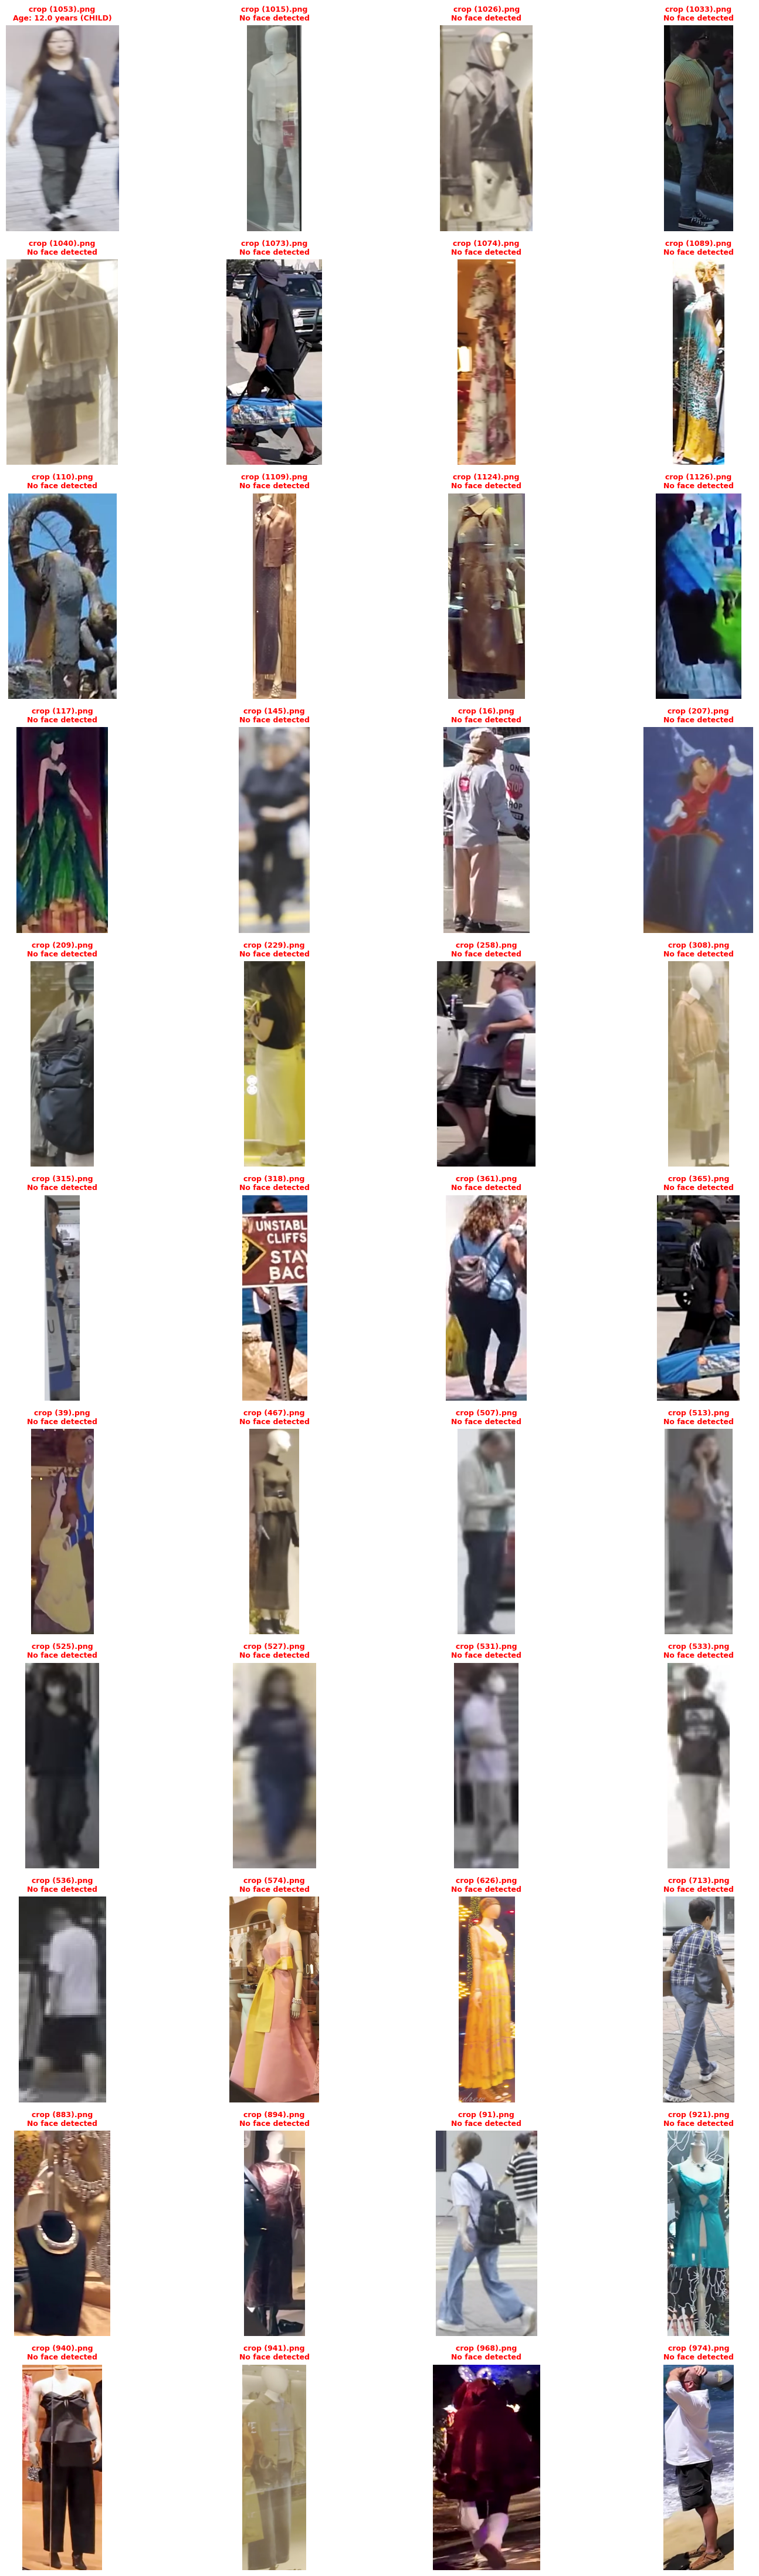

In [23]:
import matplotlib.pyplot as plt

# Visualize rejected images (age < 13 or no face detected)
rejected_images = {name: result for name, result in all_results.items() if not result['passes_age_check']}

print(f"Rejected images ({len(rejected_images)} total):")
print("="*70)

# Separate by reason
children_images = {name: result for name, result in rejected_images.items() if result['face_detected'] and result['estimated_age'] is not None}
no_face_images = {name: result for name, result in rejected_images.items() if not result['face_detected']}

print(f"  Children (age < {min_age}): {len(children_images)} images")
for name, result in sorted(children_images.items()):
    print(f"    {name}: {result['estimated_age']:.1f} years")

print(f"\n  No face detected: {len(no_face_images)} images")
for name in sorted(no_face_images.keys()):
    print(f"    {name}")

print("="*70)

# Visualize all rejected images
if rejected_images:
    # Combine all rejected images
    all_rejected_items = list(children_images.items()) + list(no_face_images.items())
    
    if all_rejected_items:
        num_images = len(all_rejected_items)
        # Calculate grid dimensions (roughly square)
        cols = min(4, (num_images + 2) // 3)  # Max 4 columns
        rows = (num_images + cols - 1) // cols  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
        
        # Flatten axes for easy iteration (even if it's a single row)
        if rows == 1 and cols == 1:
            axes = np.array([[axes]])
        elif rows == 1 or cols == 1:
            axes = axes.reshape(rows, cols)
        
        axes = axes.flatten()
        
        for idx, (img_name, result) in enumerate(all_rejected_items):
            img_path = validated_path / img_name
            img = cv2.imread(str(img_path))
            
            if img is not None:
                axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                
                if result['face_detected'] and result['estimated_age'] is not None:
                    title = f"{img_name}\nAge: {result['estimated_age']:.1f} years (CHILD)"
                    axes[idx].set_title(title, fontsize=9, fontweight='bold', color='red')
                else:
                    title = f"{img_name}\nNo face detected"
                    axes[idx].set_title(title, fontsize=9, fontweight='bold', color='red')
                
                axes[idx].axis('off')
        
        # Hide unused subplots
        for idx in range(len(all_rejected_items), len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
else:
    print("No rejected images!")


## Design Notes

**Architecture Decision: Face Detection in Phase 4, Not Phase 3**

Phase 3 (fullbody_validation.ipynb) was simplified to use **pose-only detection** (YOLOv8-Pose keypoints). Face detection was removed because:
1. **Redundancy**: Phase 4's InsightFace already includes built-in face detection
2. **Efficiency**: Single unified pipeline is faster than two separate detectors
3. **Accuracy**: InsightFace face detection is superior to MediaPipe for detecting real faces vs. mannequins
4. **Separation of Concerns**: Phase 3 = geometry (fullbody pose), Phase 4 = biometrics (age + face presence)

Result: Phase 4 not only filters by age but also acts as a secondary quality gate, catching edge cases Phase 3 missed (mannequins, statues, cardboard cutouts with realistic proportions).